In [502]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geogr√°ficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcci√≥n de la red en NetworkX
import scipy

# Preambulo

En esta secci√≥n cargamos los datos y los visualizamos. Tambi√©n construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [ac√°](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). Tambi√©n descargamos los barrios de CABA como complemento para los gr√°ficos.

In [503]:
# Leemos el archivo, retenemos aquellos museos que est√°n en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualizaci√≥n

<Axes: >

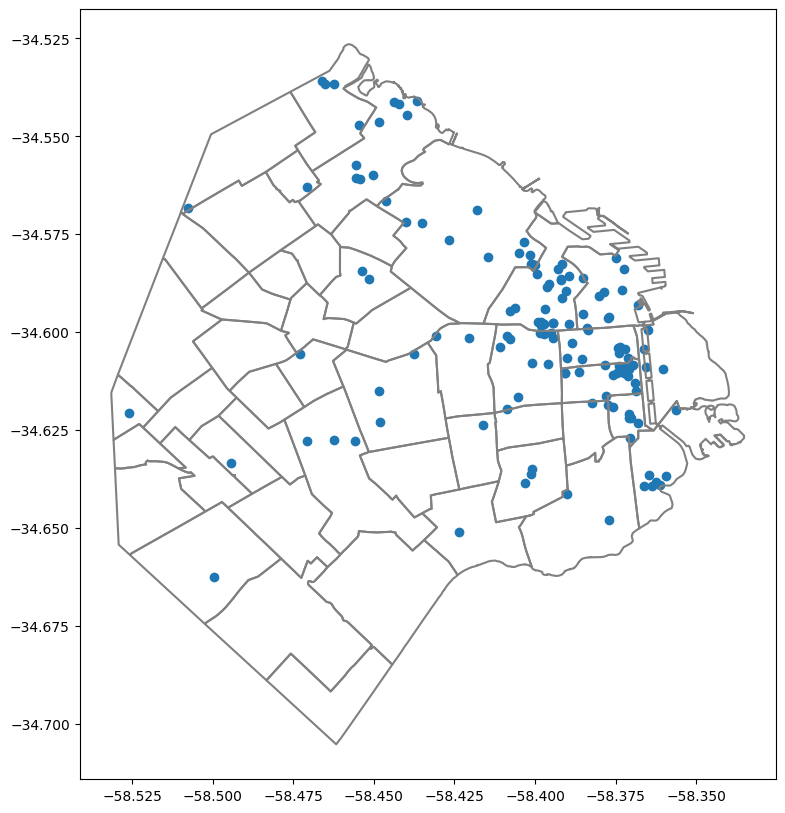

In [504]:
# Armamos el gr√°fico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## C√°lculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el c√°lculo de distancias no es una operaci√≥n obvia. Una opci√≥n es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [505]:
# En esta l√≠nea:
# Tomamos museos, lo convertimos al sistema de coordenadas de inter√©s, extraemos su geometr√≠a (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ m√°s cercanos

In [506]:
def construye_adyacencia(D,m): 
    # Funci√≥n que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores l√≥gicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que est√©n a una distancia menor o igual a la del m-esimo m√°s cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcci√≥n de la red en NetworkX (s√≥lo para las visualizaciones)

In [507]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geogr√°ficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

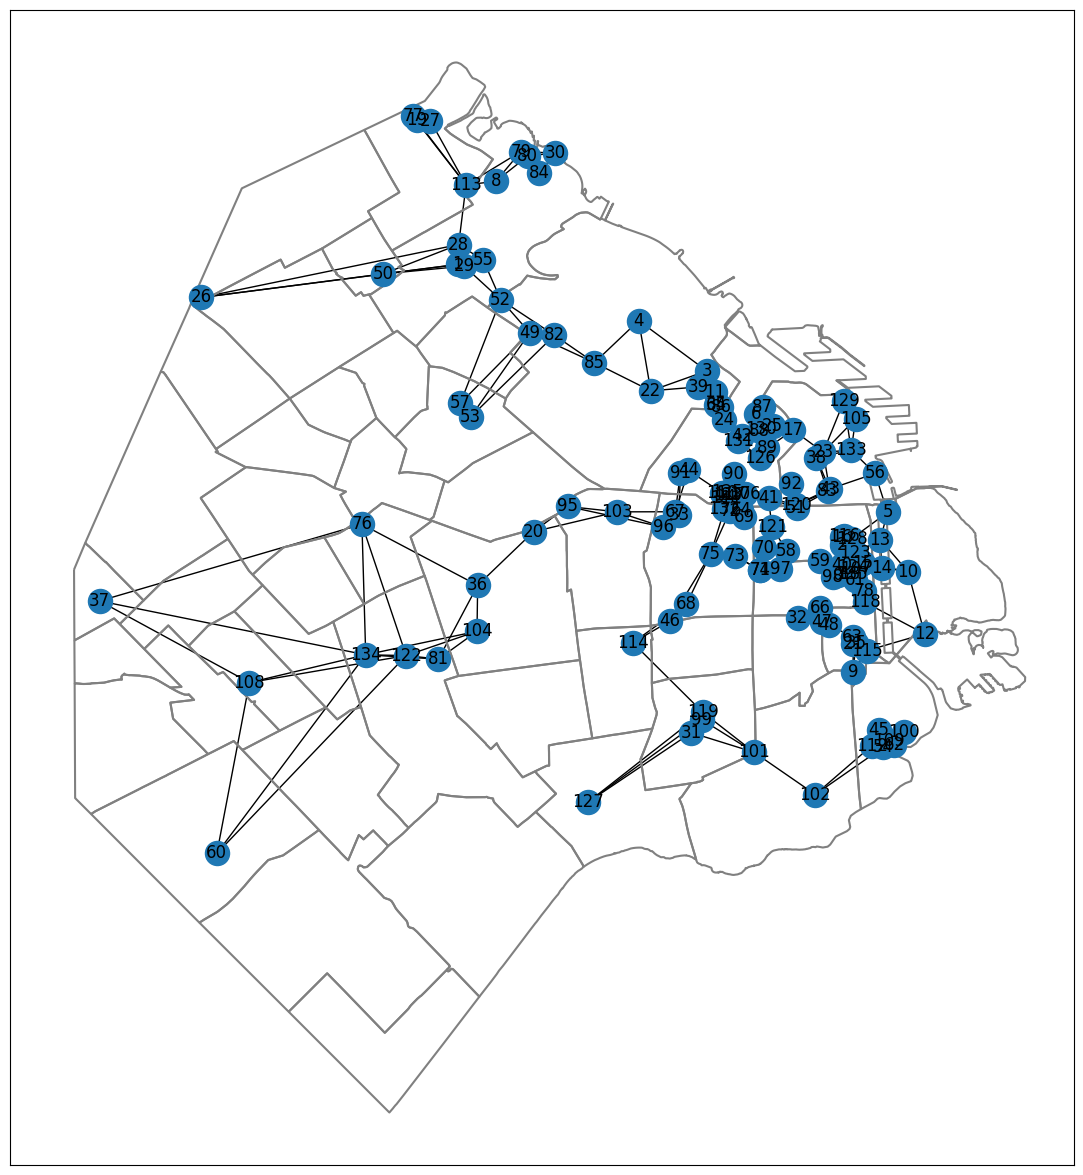

In [508]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualizaci√≥n de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

---

# Resoluci√≥n del TP 1

## Punto 1: 
----
Partiendo de la ecuaci√≥n

$$
\mathbf{p} = (1-\alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

muestre que el vector de rankings **p** es soluci√≥n de la ecuaci√≥n     $M\mathbf{p} = \mathbf{b}$  , con    $M = \frac{N}{\alpha}(I - (1-\alpha)C)$    y    $\mathbf{b} = \mathbf{1}$  .


### Resoluci√≥n

La ecuaci√≥n es:

$$
\mathbf{p} = (1-\alpha)C\mathbf{p} + \frac{\alpha}{N}\mathbf{1},
$$

luego:

$$\mathbf{p} - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\mathbf{p}I - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$(I - (1-\alpha)C)\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\frac{N}{\alpha}(I - (1-\alpha)C)\mathbf{p} = \mathbf{1}$$

y con $M = \frac{N}{\alpha}(I - (1-\alpha)C)$ resulta lo pedido: $M\mathbf{p} = \mathbf{b} = \mathbf{1}$.


## Punto 2:
----
¬øQu√© condiciones se deben cumplir para que exista una √∫nica soluci√≥n a la ecuaci√≥n del
punto anterior? ¬øSe cumplen estas condiciones para la matriz $M$ tal como fue construida
para los museos, cuando $0 < \alpha < 1$? Demuestre que se cumplen o d√© un contraejemplo.


Dado el √≠tem anterior, la ecuaci√≥n $Mp = 1$ tendr√° soluci√≥n √∫nica cuando $M$ sea inversible. Una condici√≥n necesaria y suficiente para esto es que el n√∫cleo de $M$ sea $\{0\}$.

Primero, usando el tip dado en clase, pruebo:

$$
\text{Si} \quad B \in \mathbb{R}^{n \times n} \quad \text{y} \quad \|B\|_1 < 1 \quad \text{entonces} \quad (I-B) \quad \text{es inversible}.
$$

Supongamos que existe $(I-B)^{-1}$. Entonces, si existiera $x \neq 0$ en $\mathbb{R}^{n}$ tal que $(I-B)x = 0$, tendr√≠amos:

$$
x - Bx = 0
$$

lo que equivale a

$$
x = Bx.
$$

Uso la norma-1 (que preserva la igualdad) y puedo suponer que $\|x\|_1 = 1$. Entonces:

$$
\|x\|_1 = \|Bx\|_1 \quad \Rightarrow \quad 1 = \|Bx\|_1.
$$

Adem√°s, se cumple que $\|Bx\|_1 \leq \|B\|_1 \|x\|_1$ y, usando la hip√≥tesis $\|B\|_1 < 1$, resulta:

$$
\|Bx\|_1 \leq \|B\|_1 \|x\|_1 = \|B\|_1 < 1.
$$

Por lo tanto, tenemos que:

$$
\|Bx\|_1 = 1 \quad \text{y} \quad \|Bx\|_1 < 1,
$$

lo cual es imposible. Como lo √∫nico que supusimos fue que $x \neq 0$, debe ser entonces que solamente se cumple $(I-B)x = 0$ si $x = 0$. Por lo tanto, $(I-B)$ es inversible.

---

Volviendo al problema original: $Mp = 1$ tendr√° soluci√≥n √∫nica si la matriz $M$ resulta inversible, es decir, si $(I - (1-\alpha)C)$ es inversible.

Por un lado, observamos que $\|C\|_1 = 1$ dado que, por definici√≥n, sus columnas suman 1. Por otro lado, como $0 < \alpha < 1$, se cumple que $1-\alpha < 1$.

Es decir:

$$
\|(1-\alpha)C\|_1 = (1-\alpha)\|C\|_1 < 1.
$$

Esto es an√°logo al problema anterior sobre la existencia de $(I-B)^{-1}$, por lo tanto $(I - (1-\alpha)C)^{-1}$ existe, y la soluci√≥n $p$ es √∫nica con la matriz $M$ y $\alpha$ as√≠ definidos.


## Punto 3:
----
Usando la factorizaci√≥n $LU$ implementada, encuentre el vector $\mathbf{p} = M^{-1} \mathbf{b}$ en los siguientes casos:

**a.** Construyendo la red conectando a cada museo con sus $m = 3$ vecinos m√°s cercanos, calculen el Page Rank usando $\alpha = 1/5$. Visualicen la red asignando un tama√±o a cada nodo proporcional al Page Rank que le toca.

**b.** Construyendo la red conectando a cada museo con sus $m$ vecinos m√°s cercanos, para $m = 1, 3, 5, 10$ y usando $\alpha = 1/

**c.** Para $m = 5$, considerando los valores de $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

-----

Usando los valores de $\mathbf{p}$ obtenidos para cada caso,

**a.** Identifiquen los 3 museos m√°s centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de Page Rank) en funci√≥n del par√°metro a variar (es decir, en funci√≥n de $m$ o de $\alpha$). ¬øSon estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qu√© ubicaciones son relevantes en cada caso. ¬øHay museos que s√≥lo son relevantes en redes con pocas conexiones? ¬øO museos que se vuelven m√°s relevantes mientras m√°s conexiones aparecen?

**b.** Construyan visualizaciones del mapa, usando el Page Rank para representar el tama√±o de cada museo. ¬øQu√© regiones se vuelven m√°s predominantes al aumentar $\alpha$? ¬øY al aumentar $m$?


In [509]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones as tf
from IPython.display import display
importlib.reload(tf)

<module 'template_funciones' from 'c:\\Users\\mazze\\Documents\\GIT\\ALC2025-1c-TP1\\template_funciones.py'>

In [510]:
# Definimos los valores de m a analizar
valores_m = [1, 3, 5, 10]
alfa_fijo = round(1/5, 5)

# Diccionarios para guardar matrices de adyacencia, grafos y pageranks
adyacencias_m = {}
grafos_m = {}
pageranks_m = {}

for m in valores_m:
    A = tf.construye_adyacencia(D, m)
    adyacencias_m[m] = A
    grafos_m[m] = nx.from_numpy_array(A)
    pageranks_m[m] = tf.calcula_pagerank(A, alfa_fijo)

# PageRank para distintos valores de Œ± con m=5 fijo
valores_alfa = [round(6/7, 5), round(4/5, 5), round(2/3, 5), round(1/2, 5), round(1/3, 5), round(1/5, 5), round(1/7, 5)]
m_fijo = 5
A_fijo = adyacencias_m[m_fijo]  # Ya lo calculamos arriba

pageranks_alfa = {}

for alfa in valores_alfa:
    alfa_key = round(alfa, 5)  # Redondeamos para evitar errores al usar un float como key
    p = tf.calcula_pagerank(A_fijo, alfa)
    pageranks_alfa[alfa_key] = p
    
# Layouts
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(coords['x'], coords['y']))}

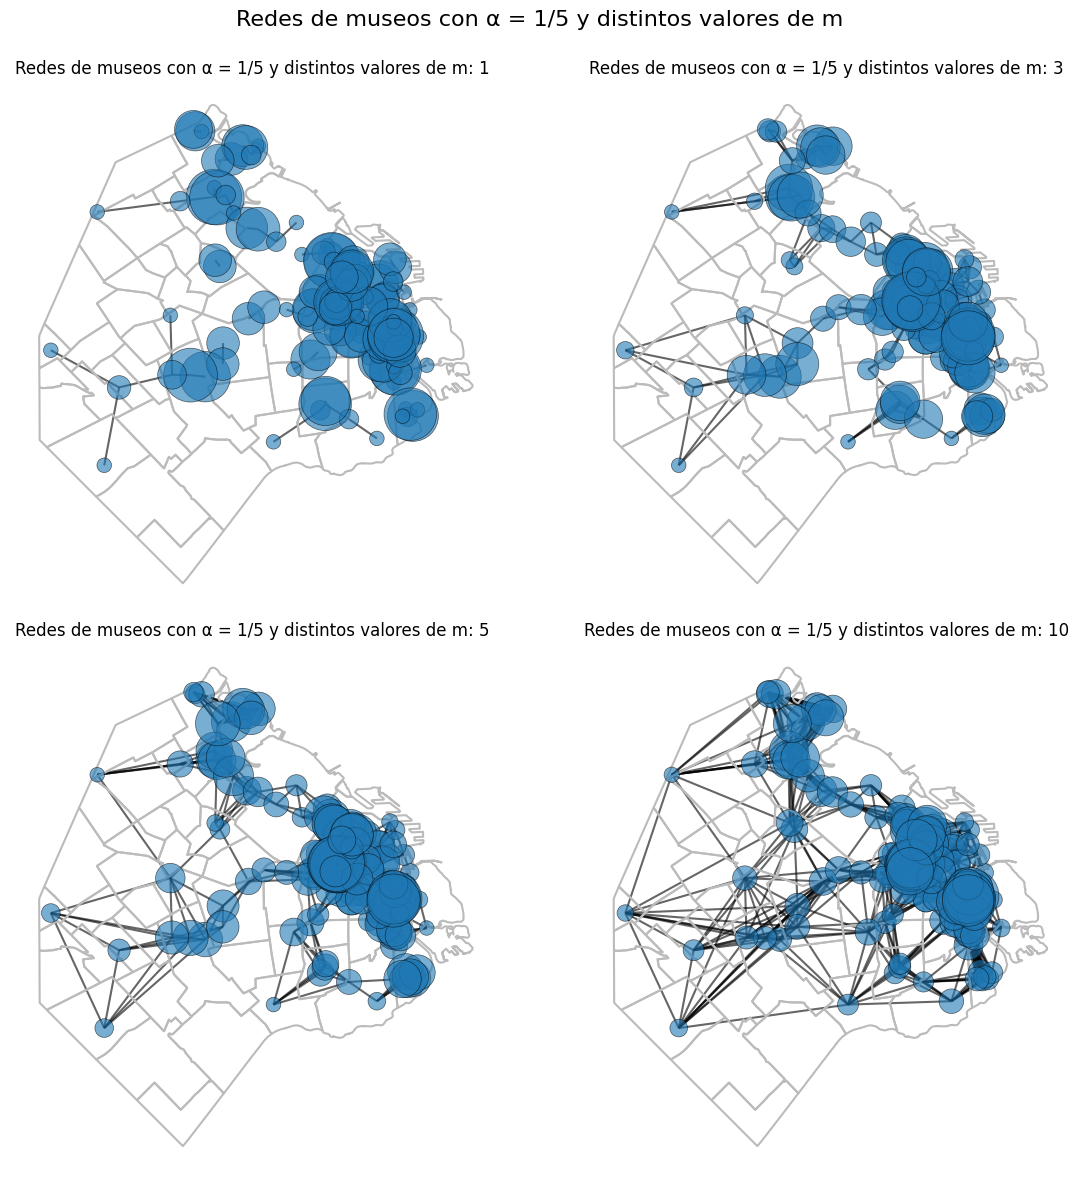

In [511]:
# Mostrar redes para distintos m (con Œ± = 1/5 fijo)
tf.graficar_redes_museos_set(
    grafos=grafos_m,
    pageranks=pageranks_m,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con Œ± = 1/5 y distintos valores de m"
)

En estos gr√°ficos se observa c√≥mo var√≠a la red de museos al modificar el par√°metro $m$, que indica con cu√°ntos vecinos se conecta cada museo (sus $m$ m√°s cercanos). A medida que $m$ aumenta, la red se vuelve progresivamente m√°s densa, y eso tiene consecuencias sobre la distribuci√≥n del PageRank.

Con valores bajos de $m$ (por ejemplo, $m = 1$ o $m = 3$), la red presenta una estructura m√°s fragmentada: aparecen peque√±as zonas relativamente aut√≥nomas, en las que ciertos museos son centrales dentro de su subregi√≥n (por ejemplo, museos ubicados en Caballito y Flores, la zona norte de CABA y Microcentro). Esto se refleja en el PageRank, donde varios nodos perif√©ricos en el grafo completo tienen una alta centralidad dentro de su grupo local.

Sin embargo, a medida que $m$ aumenta (por ejemplo, en $m = 10$), estas subregiones comienzan a conectarse entre s√≠ y se forma una estructura m√°s integrada. En este contexto, los nodos centrales del Microcentro y los de la zona norte empiezan a dominar el ranking, desplazando a aquellos que antes eran importantes solo dentro de su vecindario. Es decir, pasamos de una red con m√∫ltiples polos locales de centralidad a una red con una o dos zonas centrales m√°s clara y dominante.

Este comportamiento muestra c√≥mo el valor de $m$ influye en el grado de descentralizaci√≥n de la red: con $m$ bajos emergen estructuras locales, mientras que con $m$ altos la red converge hacia un patr√≥n de conectividad m√°s global, en el que solo unos pocos nodos concentran la mayor parte del PageRank.


---

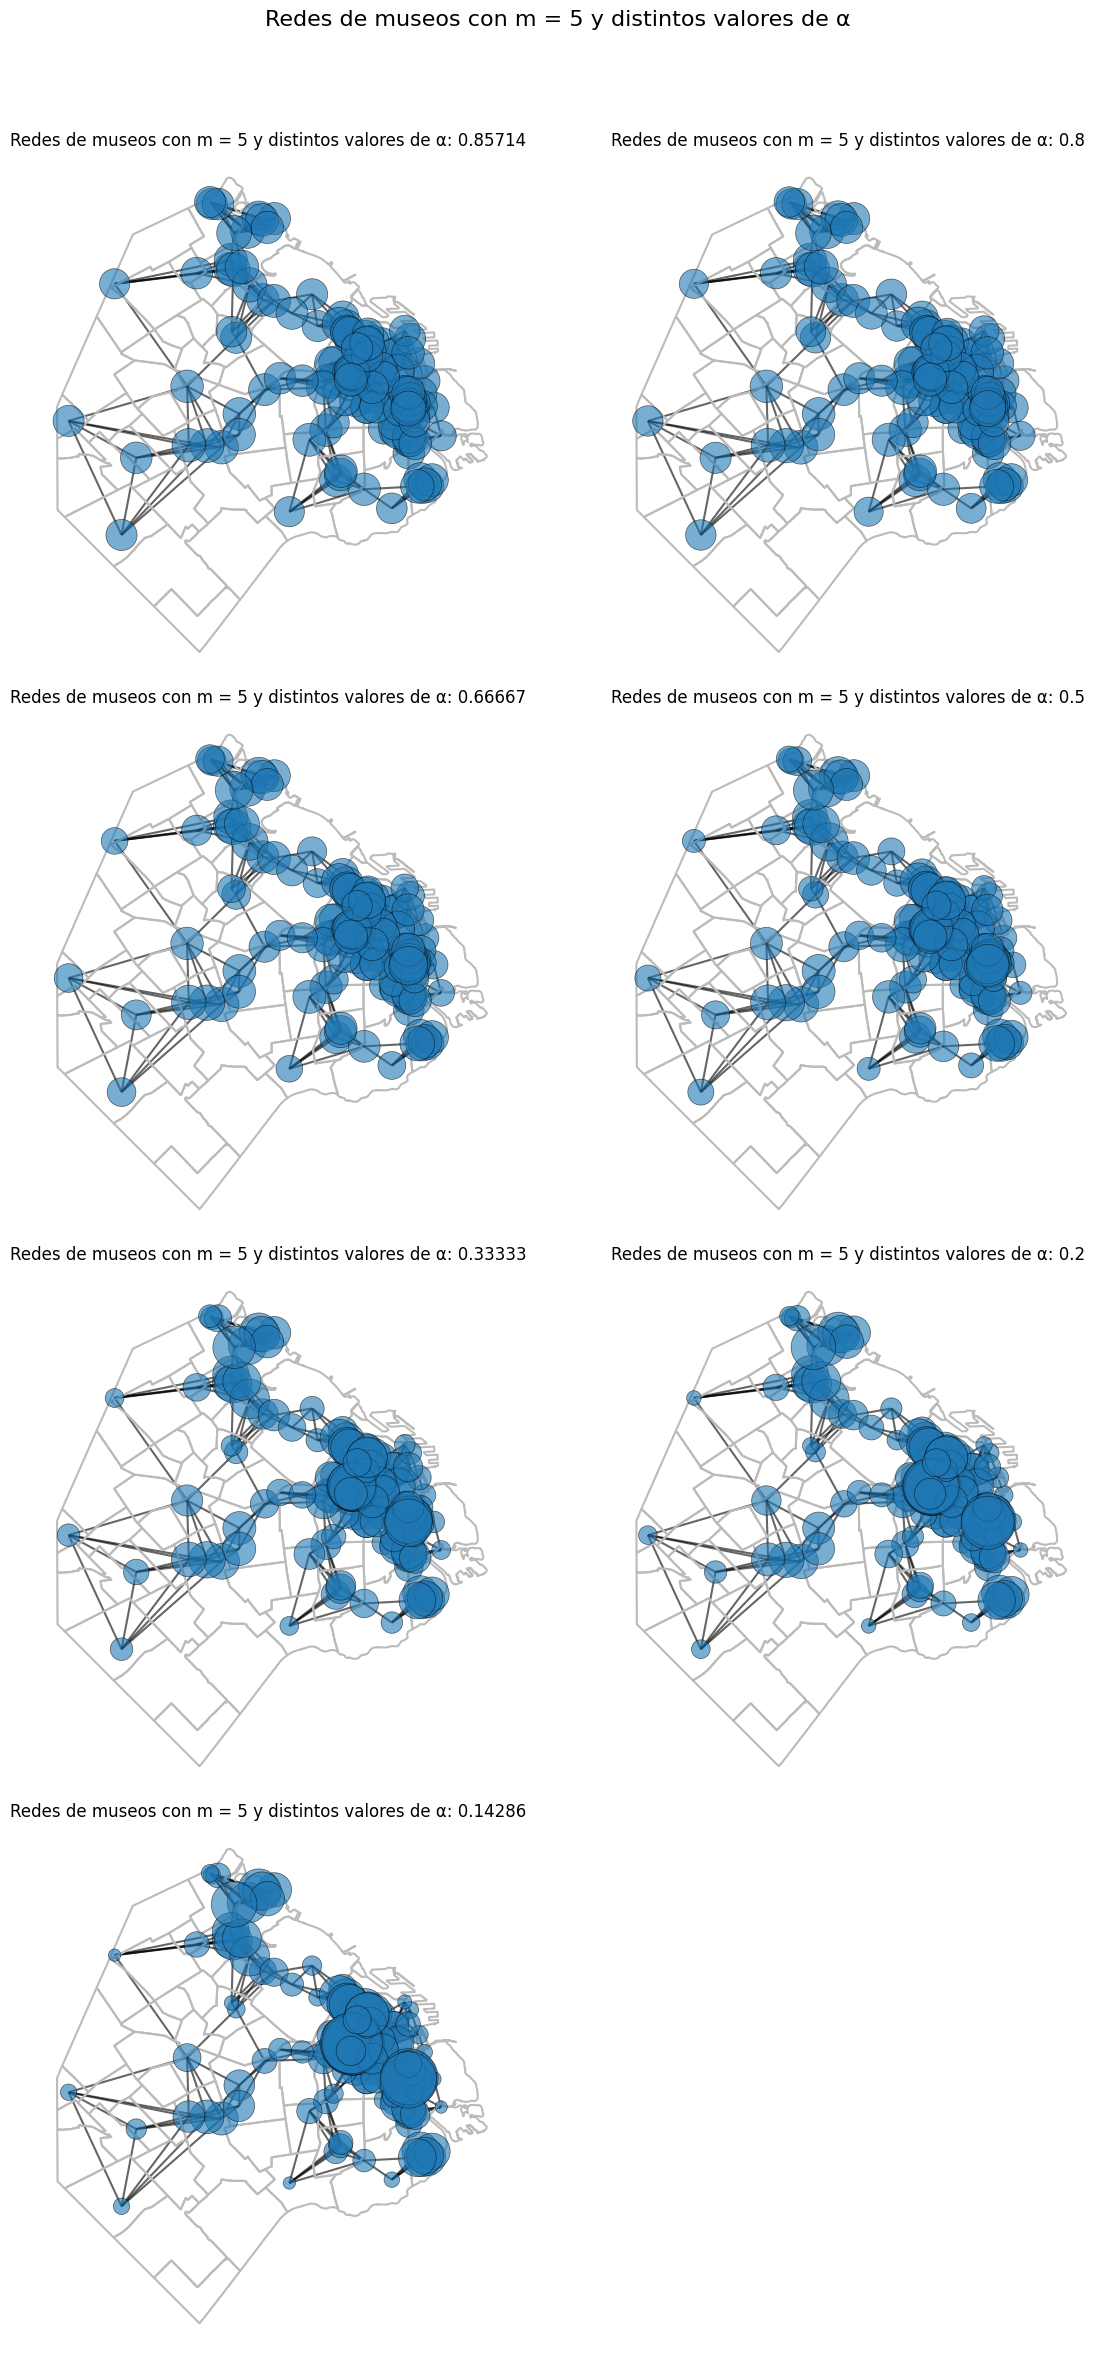

In [512]:
# Mostrar redes para distintos Œ± (con m = 5 fijo)
# Creamos un diccionario de grafos con m=5 fijo
grafos_alfa = {round(alfa, 5): grafos_m[5] for alfa in valores_alfa}

tf.graficar_redes_museos_set(
    grafos=grafos_alfa,
    pageranks=pageranks_alfa,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con m = 5 y distintos valores de Œ±"
)

En este caso, como el valor de $m$ est√° fijo en 5, todos los grafos tienen exactamente las mismas conexiones entre museos. Lo que cambia entre gr√°ficos es el valor del par√°metro $\alpha$, que controla la probabilidad de que un caminante reinicie su recorrido en un nodo aleatorio.

Cuando $\alpha$ est√° cerca de 1, por ejemplo $\alpha = \frac{6}{7}$, hay mucha probabilidad de reiniciar la caminata en cualquier museo. Eso hace que los valores de PageRank se repartan de forma bastante uniforme: todos los nodos tienen m√°s o menos el mismo tama√±o. En cambio, cuando $\alpha$ se acerca a 0, como en $\alpha = \frac{1}{7}$, el caminante sigue los enlaces de la red casi sin reiniciar, y eso acent√∫a las diferencias entre nodos. En ese caso, los museos m√°s bien ubicados o con m√°s caminos que llegan a ellos se destacan mucho m√°s.

En resumen, cuanto m√°s chico es $\alpha$, m√°s influye la estructura de la red en el resultado del PageRank. Y cuanto m√°s grande es $\alpha$, m√°s uniforme es la distribuci√≥n del ranking entre los nodos.

---

Para la segunda parte, haremos primero el an√°lisis para $m=5$ y $\alpha = \frac{1}{5}$ y haremos variar $m$ dejando $\alpha$ fijo.

In [513]:
# Obtenemos el top 3 de museos m√°s centrales para m = 5 y ùõº = 1/5
p_copy = pageranks_m[5].copy()
top_idx = []

for i in range(3):
    max_val = -1
    max_idx = -1

    # Recorremos p_copy para buscar el maximo y su posicion
    for idx in range(len(p_copy)):
        if p_copy[idx] > max_val:
            max_val = p_copy[idx]
            max_idx = idx
        
    top_idx.append(max_idx)
    print(f"{i+1}¬∞ ‚Üí Museo #{max_idx} con PageRank = {max_val:.4f}")
        
    # Lo sacamos para encontrar el resto del Top
    p_copy[max_idx] = -1

1¬∞ ‚Üí Museo #93 con PageRank = 0.0217
2¬∞ ‚Üí Museo #125 con PageRank = 0.0216
3¬∞ ‚Üí Museo #117 con PageRank = 0.0211


Ahora analizaremos la evoluci√≥n de estos 3 museos de referencia al variar $m$.

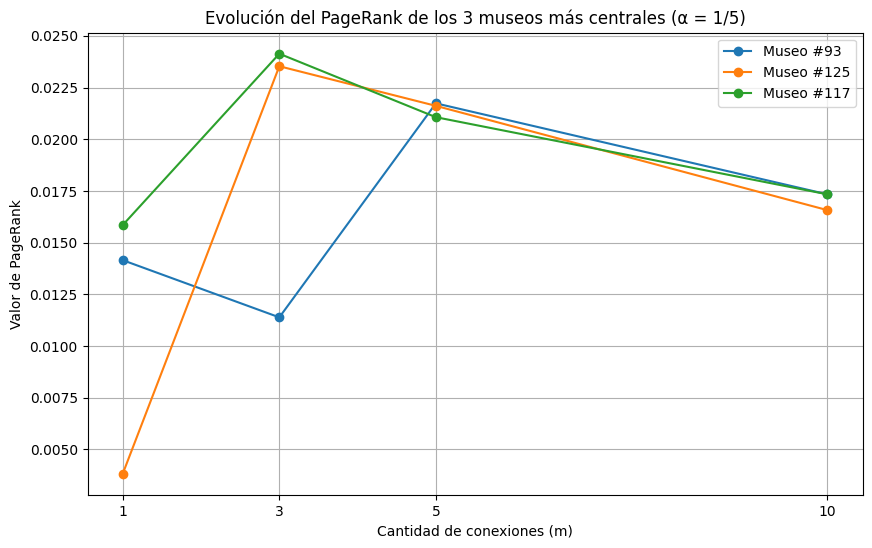

In [514]:
# Inicializamos un diccionario vac√≠o para guardar la evoluci√≥n de cada museo
evolucion_p_m = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_m:
    p = pageranks_m[m]
    for idx in top_idx:
        evolucion_p_m[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_m, evolucion_p_m[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_m = ["1", "3", "5", "10"]
plt.xticks(valores_m, labels_m)  # Aseguramos que se usen los valores como etiquetas expl√≠citas

plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Valor de PageRank")
plt.title("Evoluci√≥n del PageRank de los 3 museos m√°s centrales (Œ± = 1/5)")
plt.grid(True)
plt.legend()
plt.show()

Se aprecia que, en general, los valores de PageRank tienden a incrementarse cuando pasamos de $m = 1$ a $m = 3$, y luego decrecen levemente al seguir aumentando $m$ a $5$ y $10$. Esto puede interpretarse como un efecto de dispersi√≥n: con pocas conexiones, la importancia se concentra en unos pocos nodos; a medida que se agregan m√°s enlaces, la centralidad se redistribuye y los valores de PageRank tienden a equilibrarse entre m√°s museos.

---

Hacemos lo mismo pero en funci√≥n de $\alpha$:

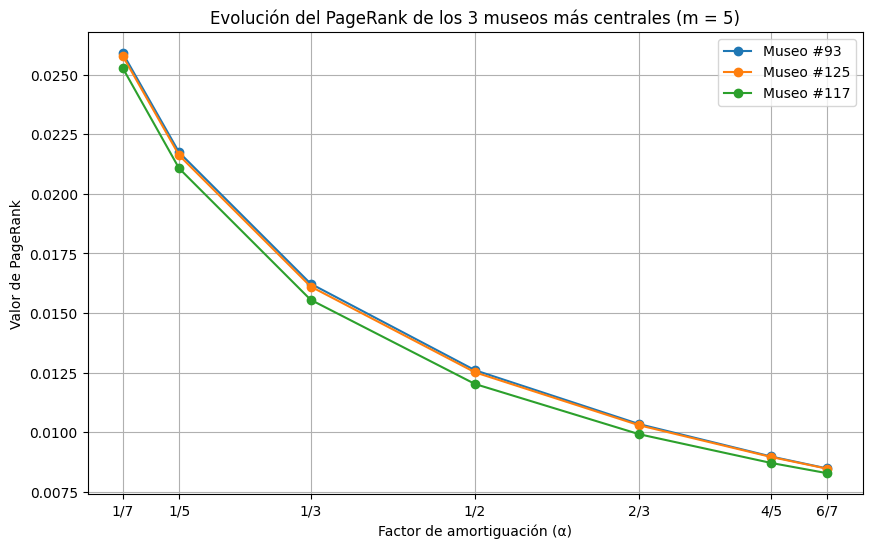

In [515]:
# Inicializamos un diccionario vac√≠o para guardar la evoluci√≥n de cada museo
evolucion_p_alfa = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_alfa:
    p = pageranks_alfa[m]
    for idx in top_idx:
        evolucion_p_alfa[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, evolucion_p_alfa[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_alfa = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]
plt.xticks(valores_alfa, labels_alfa)

plt.xlabel("Factor de amortiguaci√≥n (Œ±)")
plt.ylabel("Valor de PageRank")
plt.title("Evoluci√≥n del PageRank de los 3 museos m√°s centrales (m = 5)")
plt.grid(True)
plt.legend()
plt.show()

Se ve que cuanto m√°s grande es $\alpha$, m√°s se reparten los valores de PageRank entre todos los nodos (recordemos que p es un vector estoc√°stico), y los m√°s centrales bajan un poco. Esto pasa porque al aumentar $\alpha$, el modelo depende m√°s de c√≥mo est√° conectada la red, y menos del "salto aleatorio". En cambio, cuando $\alpha$ es chico, se favorece m√°s a los nodos a los que se llega seguido, y eso hace que se destaquen m√°s en el ranking.

---

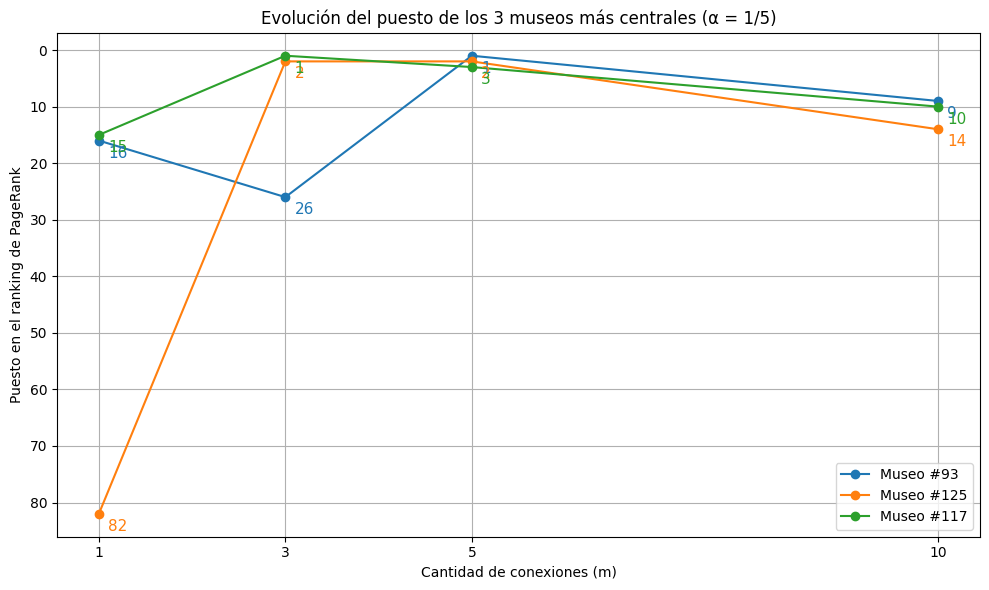

In [516]:
# Diccionario para guardar la evoluci√≥n del puesto de cada museo
puestos_m = {idx: [] for idx in top_idx}

for m in valores_m:
    p = pageranks_m[m]
    
    # Vector de √≠ndices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]  
    
    for idx in top_idx:
        # np.where devuelve los √≠ndices donde se cumple la condici√≥n del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_m[idx].append(puesto)


colores = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))

for color, idx in zip(colores, top_idx):
    puestos = puestos_m[idx]
    plt.plot(valores_m, puestos, marker='o', label=f"Museo #{idx}", color=color)

    for x, y in zip(valores_m, puestos):
        plt.text(x + 0.1, y + 3, str(y), fontsize=11, color=color)

plt.xticks(valores_m, labels_m)
plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evoluci√≥n del puesto de los 3 museos m√°s centrales (Œ± = 1/5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que al aumentar el valor de $m$ (entre 1 y 10), se observa una notable inestabilidad en el ranking de los museos m√°s centrales. Uno de los museos que ocupa el segundo puesto con $m = 5$ cae al puesto 82 cuando m = 1. Esta gran variaci√≥n sugiere que el n√∫mero de conexiones tiene un impacto decisivo en la estructura de la red: con pocos enlaces ($m$ chico), la red es m√°s local y sensible a cambios puntuales; en cambio, a medida que $m$ crece, el ranking se estabiliza y los museos centrales tienden a mantener posiciones altas. A partir de $m = 5$, los rankings se vuelven m√°s estables entre s√≠.

---

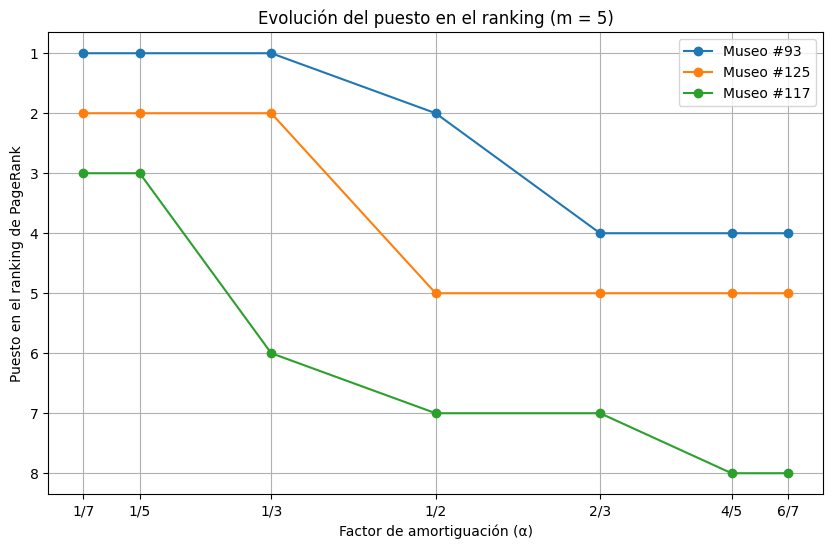

In [517]:
# Diccionario para guardar la evoluci√≥n del puesto de cada museo
puestos_alfa = {idx: [] for idx in top_idx}

for alfa in valores_alfa:
    p = pageranks_alfa[alfa]
    
    # Vector de √≠ndices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]
    
    for idx in top_idx:
        # np.where devuelve los √≠ndices donde se cumple la condici√≥n del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_alfa[idx].append(puesto)

# Graficamos los resultados
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, puestos_alfa[idx], marker='o', label=f"Museo #{idx}")

plt.xticks(valores_alfa, labels_alfa)  # Ya hab√≠as definido estas etiquetas como fracciones
plt.xlabel("Factor de amortiguaci√≥n (Œ±)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evoluci√≥n del puesto en el ranking (m = 5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

Al variar $\alpha$ (entre 1/7 y 6/7), se evidencia una estabilidad mucho mayor en los puestos de los museos m√°s centrales. Los tres museos analizados mantienen posiciones altas con variaciones peque√±as y progresivas. Esto indica que el PageRank es menos sensible a cambios en $\alpha$ (dentro del rango considerado), y que los museos m√°s importantes siguen siendo favorecidos en el ranking incluso cuando el peso relativo de la caminata aleatoria frente al salto aleatorio var√≠a.

---

## Punto 4:

Si $V_{0}$ es la distribuci√≥n inicial, o cantidad inicial de visitantes en cada museo, y considero la matriz C, entonces para un elemento i cualquiera de $CV_{0}$, tengo que i = $c_{1,i}*v_{1} + c_{2,i}*v_{2} + \ldots + c_{n,i}*v_{n}$ que no es otra cosa que la suma de la cantidad de visitantes que cada museo distinto del i (si i=j $c_{ij} = 0$) le aporta al i.

De forma an√°loga pero partiendo de otra cantidad inicial $V_{1} = CV_{0}$ nos dara la cantidad de visitantes por museo luego de 2 pasos.
Al final, como menciona el tip, $C^{k}V_{0} = V_{k}$ nos dara la cantida de visitantes por museo luego de k pasos.

Dada la matriz $B$ y $V_{0}$ tengo que: $Bv_{0} = C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$. Por lo mencionado antes, resulta que, por ejemplo: $C^{0}v_{0} + C^{1}v_{0}$ ser√° la cantidad total de gente que visit√≥ cada museo luego de dos pasos.
En general $C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$ da la totalidad de visitantes por museo, es decir, w, luego de k pasos.
Si asumo la existencia de $B^{-1}$, para cada r, entonces para cada total de visitantes por museo w tengo la distribuci√≥n inicial $V_{0}$ que lo gener√≥.

## Punto 5:

Usando la ecuaci√≥n  

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

y suponiendo que las personas dan \( $r = 3$ \) pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $
\|\mathbf{v}\|_1 $
, a partir del vector $ \mathbf{w}\ $ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuaci√≥n:

$$
C_{ji} = P(i \to j) = \frac{f(d_{ij})}{\sum_{k=1,\, k \ne i}^{N} f(d_{ik})}
$$


Para esto:

- Construya una funci√≥n `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $ D $ y retorne la matriz $ C $ definida en la ecuaci√≥n anterior.
- Construya una funci√≥n `calcula_B(C, r)` que reciba la matriz $ C $ y el n√∫mero de pasos $ r $ como argumento, y retorne la matriz $B$ de la ecuaci√≥n:
$
\mathbf{v} = B^{-1} \mathbf{w}
$.
- Utilice la funci√≥n `calculaLU` para resolver la ecuaci√≥n:

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

In [518]:
w = np.loadtxt("visitas.txt") #Arma vector w a partir del archivo
C = tf.calcula_matriz_C_continua(D) # Construye la matriz de transiciones C
B = tf.calcula_B(C, 3) # Calcula la matriz B que representa la relaci√≥n entre el total de visitas y el n√∫mero inicial de visitantes suponiendo que cada visitante realiz√≥ 3 pasos
v = tf.resolver_con_LU(B, w)

visitantes_totales = np.sum(np.abs(v)) # Calcula norma 1 de v
print("Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es ", visitantes_totales)

Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es  136605.0


## Punto 6:

Supongan que se enteran de que el n√∫mero total de visitantes por museo $ \mathbf{w} $ tiene un error del 5%, y necesitan estimar c√≥mo se propaga ese error a la estimaci√≥n del n√∫mero inicial $ \mathbf{v} $ de visitantes. Llamemos $ \tilde{\mathbf{w}} $ y $ \tilde{\mathbf{v}} $ los valores reales para el total de visitas y el total de primeras visitas respectivamente.

Si expresamos este problema usando el n√∫mero de condici√≥n, tenemos que:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Calcule el n√∫mero de condici√≥n de $ B $ y estime la cota para el error de estimaci√≥n de $ \mathbf{v} $.

In [519]:
cond_B = tf.condicion_1_por_LU(B)# N√∫mero de condici√≥n de B
error_v = cond_B * 0.05 # La cota para el error de estimaci√≥n de v

print("El n√∫mero de condici√≥n 1 de B es", cond_B)
print("La cota para el error de estimaci√≥n de v es", error_v)

El n√∫mero de condici√≥n 1 de B es 5.051771176665007
La cota para el error de estimaci√≥n de v es 0.2525885588332503


---

# Resoluci√≥n del TP 2

## Punto 1. Autovectores y autovalores de $L$ y $R$

### a. Mostrar que el vector $\mathbf{1}$ es autovector de $L$ y $R$

Sea $\mathbf{1}$ el vector columna con todos sus componentes iguales a 1, es decir:
$$
\mathbf{1} = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}
$$

Recordemos que la matriz laplaciana se define como $L = K - A$, donde $K$ es la matriz diagonal de grados, $K_{ii} = k_i = \sum_{j=1}^N A_{ij}$.

Entonces:
$$
L \mathbf{1} = (K - A)\mathbf{1} = K \mathbf{1} - A \mathbf{1}
$$

Notar que:
- $K \mathbf{1}$ devuelve el vector de grados: $K \mathbf{1} = \mathbf{k}$
- $A \mathbf{1}$ tambi√©n devuelve el vector de grados: $A \mathbf{1} = \mathbf{k}$, porque cada fila de $A$ suma los enlaces de cada nodo.

Entonces:
$$
L \mathbf{1} = \mathbf{k} - \mathbf{k} = \mathbf{0}
\Rightarrow \mathbf{1} \text{ es autovector de } L \text{ con autovalor } 0
$$

Para la matriz de modularidad $R = A - P$, con $P_{ij} = \frac{k_i k_j}{2E}$:

$$
R \mathbf{1} = A \mathbf{1} - P \mathbf{1} = \mathbf{k} - P \mathbf{1}
$$

Veamos qu√© pasa con $P \mathbf{1}$:

$$
(P \mathbf{1})_i = \sum_{j=1}^N P_{ij} = \sum_{j=1}^N \frac{k_i k_j}{2E} = \frac{k_i}{2E} \sum_{j=1}^N k_j
$$


Recordemos que el grado $k_i$ de un nodo $i$ se define como la cantidad de conexiones que tiene, es decir:

$$
k_i = \sum_{j=1}^{N} A_{ij}
$$

Entonces, la suma total de los grados de todos los nodos es:

$$
\sum_{i=1}^{N} k_i = \sum_{i=1}^{N} \sum_{j=1}^{N} A_{ij} = 2E
$$

Por lo tanto, tenemos que:

$$
\frac{k_i}{2E} \sum_{j=1}^N k_j = \frac{k_i 2E}{2E} = k_i
$$

As√≠, obtuvimos que:

$$
(P \mathbf{1})_i = k_i
\Rightarrow P \mathbf{1} = \mathbf{k}
$$

Finalmente, esto implica que:

$$
R \mathbf{1} = \mathbf{k} - \mathbf{k} = \mathbf{0}
\Rightarrow \mathbf{1} \text{ es autovector de } R \text{ con autovalor } 0
$$

**Observaci√≥n**: este autovector representa una partici√≥n donde todos los nodos est√°n en el mismo grupo (sin dividir la red).

---

### b. Ortogonalidad de autovectores con distintos autovalores

Sea $M$ una matriz **sim√©trica** (vale para $L$ o $R$), y $\mathbf{v}_1$, $\mathbf{v}_2$ dos autovectores asociados a autovalores $\lambda_1 \neq \lambda_2$.

Como $M \mathbf{v}_1 = \lambda_1 \mathbf{v}_1$ y $M \mathbf{v}_2 = \lambda_2 \mathbf{v}_2$, veamos qu√© pasa con:

$$
\mathbf{v}_1^T M \mathbf{v}_2 = \mathbf{v}_1^T \lambda_2 \mathbf{v}_2 = \lambda_2 \mathbf{v}_1^T \mathbf{v}_2
\quad \text{y tambi√©n} \quad
\mathbf{v}_2^T M \mathbf{v}_1 = \mathbf{v}_2^T \lambda_1 \mathbf{v}_1 = \lambda_1 \mathbf{v}_2^T \mathbf{v}_1
$$

Pero tambi√©n: $\mathbf{v}_1^T M \mathbf{v}_2 = (\mathbf{v}_1^T M \mathbf{v}_2)^T$ ya que es un escalar. Siguiendo:

$$
\mathbf{v}_1^T M \mathbf{v}_2 = (\mathbf{v}_1^T M \mathbf{v}_2)^T = \mathbf{v}_2^T M^T \mathbf{v}_1 = \mathbf{v}_2^T M \mathbf{v}_1
$$

Con lo cual:

$$
\lambda_2 \mathbf{v}_1^T \mathbf{v}_2 = \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 
\Rightarrow \lambda_2 \mathbf{v}_1^T \mathbf{v}_2 - \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 = 0
$$

Y como $\mathbf{v}_1^T \mathbf{v}_2$ y $\mathbf{v}_2^T \mathbf{v}_1$ definen el mismo porducto escalar, son iguales. As√≠:

$$
\lambda_2 \mathbf{v}_1^T \mathbf{v}_2 - \lambda_1 \mathbf{v}_2^T \mathbf{v}_1 = 0
\Rightarrow (\lambda_2 - \lambda_1)\mathbf{v}_1^T \mathbf{v}_2 = 0
$$

Como por hip√≥tesis $\lambda_1 \neq \lambda_2$ entonces $\mathbf{v}_1^T \mathbf{v}_2 = 0$


Es decir, $\mathbf{v}_1$ y $\mathbf{v}_2$ son ortogonales.

En conclusi√≥n, **autovectores con autovalores distintos son ortogonales** (para matrices sim√©tricas).


---


### c. Si $\mathbf{v}$ es autovector de autovalor $\lambda \neq 0$, entonces $\sum_i v_i = 0$

Sabemos que $\mathbf{1}$ es autovector de $L$ y $R$ con autovalor 0 (punto **a.**). Sea $\mathbf{v}$ un autovector con autovalor $\lambda \neq 0$, entonces:

$$
M \mathbf{v} = \lambda \mathbf{v}
$$

Como $\mathbf{1}$ y $\mathbf{v}$ son autovectores de distintos autovalores, son ortogonales (punto **b.**):

$$
\mathbf{1}^T \mathbf{v} = \sum_i v_i = 0
$$

---


## Punto 2: Extensiones del metodo de la potencia
Consideramos una matriz $M \in \mathbb{R}^{n \times n}$ diagonalizable con autovalores $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_n$, y autovector $\mathbf{v}_i$ asociado a $\lambda_i$.
### a. Shifting de autovalores:
Queremos mostrar que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$, con los mismos autovectores $\mathbf{v}_i$, y concluir que si $\mu + \lambda_i \neq 0 \ \forall i$, entonces $M + \mu I$ es inversible.
#### Demostraci√≥n
Sea $\mathbf{v}_i$ un autovector de $M$ con autovalor $\lambda_i$, es decir, $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$. Consideremos la matriz $M + \mu I$, entonces:

$$
(M + \mu I) \mathbf{v}_i = M \mathbf{v}_i + \mu I \mathbf{v}_i = \lambda_i \mathbf{v}_i + \mu \mathbf{v}_i = (\lambda_i + \mu) \mathbf{v}_i.
$$

Por lo tanto, $\mathbf{v}_i$ es un autovector de $M + \mu I$ con autovalor $\gamma_i = \lambda_i + \mu$.

Si $\mu + \lambda_i \neq 0 \ \forall i$, entonces $\gamma_i \neq 0 \ \forall i$, y para ver si $M + \mu I$ es inversible, hay que ver que $det(M + \mu I) \neq 0$.

Pero el determinante de una matriz se puede calcular como el producto de sus autovalores, y si todos los autovalores de $M + \mu I \neq 0$ entonces $det(M + \mu I) \neq 0$ y por lo tanto, $M + \mu I$ es inversible.

### b. Metodo de la potencia inverso
Dado $\mu > 0$, mostraremos que $L + \mu I$ es inversible, siendo $L$ la matriz laplaciana definida como $L = K - A$, y que aplicar el m√©todo de la potencia a $(L + \mu I)^{-1}$ converge al autovector asociado al autovalor m√°s chico de $L + \mu I$ si se parte de una semilla adecuada. Adem√°s, en caso que haya un solo autovector asociado a dicho autovalor, indicaremos cu√°l es y cu√°nto vale su autovalor.


#### Demostraci√≥n

Empecemos observando que $L$ es sim√©trica, ya que $K$ es diagonal, entonces $K^T = K$ y adem√°s A es la matriz de adyacencia de una red no dirigida, por lo que es sim√©trica por construcci√≥n. As√≠, tenemos entonces que $L^{T} = (K-A)^T = K^T - A^T = K - A = L$

Adem√°s, vimos en la introducci√≥n que se puede mostrar que $L$ es **semidefinida positiva**, es decir, que todos sus autovalores son no negativos. 

Luego, por el inciso **a**, vimos que los autovalores de $L + \mu I$ son $\gamma_i = \lambda_i + \mu$. Como $\mu > 0$ y $\lambda_i \geq 0$, tenemos que $\gamma_i = \lambda_i + \mu > 0 \ \forall i$. Por lo tanto, todos los autovalores de $L + \mu I$ son positivos y $L + \mu I$ **es inversible**.

Sea $\mathbf{v}_i$ autovector de $L + \mu I$ con autovalor $\gamma_i = \lambda_i + \mu$, entonces $(L + \mu I)\mathbf{v}_i = \gamma_i \mathbf{v}_i$. Aplicando $(L + \mu I)^{-1}$ a ambos lados, tenemos que $(L + \mu I)^{-1} (L + \mu I)\mathbf{v}_i = (L + \mu I)^{-1}\gamma_i \mathbf{v}_i$
$\Rightarrow \mathbf{v}_i = \gamma_i (L + \mu I)^{-1} \mathbf{v}_i$

Por lo que tenemos que $(L + \mu I)^{-1}\mathbf{v}_i = \frac{1}{\gamma_i} \mathbf{v}_i$. Es decir, $\mathbf{v}_i$ es autovector de $(L + \mu I)^{-1}$ con autovalor $\frac{1}{\gamma_i} = \frac{1}{\lambda_i + \mu}$.

Ten√≠amos que los autovalores de $L + \mu I$ son $\gamma_1 \geq \gamma_2 \geq \cdots \geq \gamma_n > 0$, entonces los autovalores de $(L + \mu I)^{-1}$ son de la forma:

$$
\frac{1}{\gamma_n} \geq \cdots \geq \frac{1}{\gamma_2} \geq  \frac{1}{\gamma_1} > 0.
$$

Siendo $\frac{1}{\gamma_n}$ el mayor autovalor de $(L + \mu I)^{-1}$ y $\gamma_n = \lambda_n + \mu$ el correspondiente al menor autovalor de $L + \mu I$, teniendo ambos el **mismo autovector**.

Recordemos que $\lambda_n = 0$ es el menor autovalor de $L$ con autovector $\mathbf{1}$. Por el inciso **a**, el autovector asociado a $\gamma_n = \lambda_n + \mu = \mu$ es tambi√©n $\mathbf{1}$, con lo cual es a su vez autovector de $\frac{1}{\gamma_n} = \frac{1}{\lambda_n + \mu} = \frac{1}{\mu}$.

Finalmente, podemos conlcuir que el m√©todo de la potencia aplicado a $(L + \mu I)^{-1}$ converge al autovector asociado al autovalor m√°s grande de esta matriz, que corresponde al autovalor m√°s chico de $L$. Este es $\lambda_n = 0$ con autovector $\mathbf{v}_n = \mathbf{1}$, y su autovalor en $(L + \mu I)^{-1}$ es $\frac{1}{\mu}$.

### c. Deflacion de Hotelling

Suponiendo que $M$ es sim√©trica (y por lo tanto admite una base ortogonal de autovectores), queremos mostrar que $M - \lambda_1 \frac{\mathbf{v}_1 \mathbf{v}_1^T}{\mathbf{v}_1^T \mathbf{v}_1}$ tiene los mismos autovectores que $M$, pero el autovalor asociado a $\mathbf{v}_1$ es igual a cero.

#### Demostraci√≥n
Dado que $M$ es sim√©trica, tiene una base ortogonal de autovectores ${ \mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_n }$, con $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$. Adem√°s, $\mathbf{v}_i^T \mathbf{v}_j = 0$ si $i \neq j$. Sin p√©rdida de generalidad, asumiremos $\mathbf{v}_i^T \mathbf{v}_i = 1$ (autovectores normalizados).
Consideremos entonces la matriz $\tilde{M} = M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T$ y veamos c√≥mo act√∫a sobre los autovectores de $M$:

Para $\mathbf{v}_1$:

$$
\tilde{M} \mathbf{v}_1 = (M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T) \mathbf{v}_1 = M \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T \mathbf{v}_1 = M \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 = \lambda_1 \mathbf{v}_1 - \lambda_1 \mathbf{v}_1 = 0.
$$

Por lo tanto, $\mathbf{v}_1$ es autovector de $\tilde{M}$ con autovalor $0$.

Para $\mathbf{v}_i$ con $i \neq 1$:

$$
\tilde{M} \mathbf{v}_i = (M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T) \mathbf{v}_i = M \mathbf{v}_i - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T \mathbf{v}_i.
$$

Dado que $M \mathbf{v}_i = \lambda_i \mathbf{v}_i$ y $\mathbf{v}_1^T \mathbf{v}_i = 0$ (por ortogonalidad), tenemos que

$$
\tilde{M} \mathbf{v}_i = \lambda_i \mathbf{v}_i - \lambda_1 \mathbf{v}_1 \cdot 0 = \lambda_i \mathbf{v}_i.
$$

Por lo tanto, $\mathbf{v}_i$ es autovector de $\tilde{M}$ con autovalor $\lambda_i$.
Concluimos que $\tilde{M} = M - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T$ tiene los mismos autovectores que $M$, salvo el autovalor asociado a $\mathbf{v}_1$ que es $0$.


---

## Punto 3: Implementaci√≥n computacional

# TP2 - Punto 3.b): An√°lisis espectral del grafo de ejemplo

En este punto, aplicaremos las funciones desarrolladas en `template_funciones_2.py` para:
1. Calcular el autovector asociado al segundo autovalor m√°s chico de la matriz Laplaciana \( L \).
2. Calcular el autovector asociado al autovalor m√°s grande de la matriz de modularidad \( R \).
3. Calcular el corte $\Lambda$ y la modularidad \( Q \) de las particiones definidas por estos autovectores.
4. Interpretar los resultados en t√©rminos del grafo de ejemplo.
5. Comparar las particiones con la partici√≥n esperada.

In [520]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones_2 as tf2
import networkx as nx
importlib.reload(tf2)

# Matriz de adyacencia del grafo de ejemplo
A_ejemplo = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

In [521]:
# Calculamos la matriz Laplaciana L
L = tf2.calcula_L(A_ejemplo)

# Calculamos la matriz de modularidad R
R = tf2.calcula_R(A_ejemplo)

## C√°lculo de autovectores y particiones

1. **Segundo autovalor m√°s chico de \( L \)**:
   - Usamos `metpotI2(L, mu)` con $\mu = 0.1$ para obtener el autovector asociado a $\lambda_2(L + \mu I)$, que aproxima $\lambda_2(L)$.
   - Calculamos $s_L = \text{sign}(v_L)$, el corte $\Lambda$, y la modularidad \( Q \).


2. **Autovalor m√°s grande de \( R \)**:
   - Usamos `metpot1(R)` para obtener el autovector asociado al autovalor m√°s grande de \( R \).
   - Calculamos $s_R = \text{sign}(v_R)$, el corte $\Lambda$, y la modularidad \( Q \).

In [522]:
# Partici√≥n esperada: nodos 1‚Äì4 vs. 5‚Äì8
s_esperado = np.array([1, 1, 1, 1, -1, -1, -1, -1])
lambda_esperado = tf2.calcula_lambda(L, s_esperado)
Q_esperado = tf2.calcula_Q(R, s_esperado)

print("\nPartici√≥n esperada s:", s_esperado)
print("Corte Œõ (esperado):", lambda_esperado)
print("Modularidad Q (esperado):", Q_esperado)


Partici√≥n esperada s: [ 1  1  1  1 -1 -1 -1 -1]
Corte Œõ (esperado): [[2.]]
Modularidad Q (esperado): [[20.]]



## ¬øQu√© esperamos obtener?

Veamos por qu√© la partici√≥n $s = [1, 1, 1, 1, -1, -1, -1, -1]$ es la esperada, dividiendo el grafo en dos comunidades: nodos 1‚Äì4 y 5‚Äì8, con un corte $\Lambda = 2$ y modularidad $Q = 20$.

### Estructura del grafo
La matriz de adyacencia define un grafo con 8 nodos y 14 aristas:
- **Grupo 1 (nodos 1‚Äì4)**: Alta conectividad interna, con 6 aristas (1‚Äì2, 1‚Äì3, 1‚Äì4, 2‚Äì3, 2‚Äì4, 3‚Äì4).
- **Grupo 2 (nodos 5‚Äì8)**: Tambi√©n denso, con 6 aristas (5‚Äì6, 5‚Äì7, 5‚Äì8, 6‚Äì7, 6‚Äì8, 7‚Äì8).
- **Conexiones entre grupos**: Solo dos aristas: 3‚Äì6 y 4‚Äì5.

### Por qu√© $s = [1, 1, 1, 1, -1, -1, -1, -1$:
Este es el resultado m√°s intuitivo que esperamos, ya que los nodos 1‚Äì4 forman un subgrafo denso, al igual que los nodos 5‚Äì8. Asignar $s_i = 1$ a 1‚Äì4 y $s_i = -1$ a 5‚Äì8 tiene sentido ya que separa estas comunidades, minimizando las conexiones entre ellas.

### Por qu√© $\Lambda = 2$:
- El corte $\Lambda$ es el n√∫mero de aristas entre los grupos definidos por $s$.
- Con $s = [1, 1, 1, 1, -1, -1, -1, -1]$:
  - Arista 3‚Äì6: Nodo 3 ($s_3 = 1$) conectado al nodo 6 ($s_6 = -1$).
  - Arista 4‚Äì5: Nodo 4 ($s_4 = 1$) conectado al nodo 5 ($s_5 = -1$).
- Total: $\Lambda = 2$, un corte m√≠nimo que refleja la baja conectividad entre los grupos.
- Otras particiones (e.g., 1‚Äì3 vs. 4‚Äì8) generar√≠an m√°s aristas cortadas, aumentando $\Lambda$.

### Por qu√© $Q = 20$:
- La modularidad $Q$ mide la densidad de conexiones dentro de los grupos comparada con un grafo aleatorio con los mismos grados.
- Para $s = [1, 1, 1, 1, -1, -1, -1, -1]$:
  - **Conexiones internas**: 6 aristas en el grupo 1‚Äì4 y 6 en el grupo 5‚Äì8.
  - **Modelo aleatorio**: La matriz $R$ resta las conexiones esperadas ($\frac{k_i k_j}{(2E)}$, donde $E = 14$ es el n√∫mero de aristas).
  - **C√°lculo**: $Q = \sum_{i,j} (A_{ij} - \frac{k_i k_j}{2E}) s_i s_j = 20$, indicando que los grupos son mucho m√°s densos que en un grafo aleatorio.
- El valor alto de $Q$ confirma la existencia de comunidades bien definidas.

---

In [523]:
# Calcular autovector de L
mu = 0.1  # Desplazamiento
v_L, lambda_2, converge_L = tf2.metpotI2(L, mu)
s_L = np.sign(v_L)
lambda_L = tf2.calcula_lambda(L, v_L)
Q_L = tf2.calcula_Q(R, v_L)

print("Segundo autovalor de L:", lambda_2)
print("Autovector de L:", v_L)
print("Vector s_L:", s_L)
print("Corte Œõ (L):", lambda_L)
print("Modularidad Q (L):", Q_L)
print("Convergencia:", converge_L)

# Calcular autovector de R
v_R, lambda_max_R, converge_R = tf2.metpot1(R)
s_R = np.sign(v_R)
lambda_R = tf2.calcula_lambda(L, v_R)
Q_R = tf2.calcula_Q(R, v_R)

print("\nAutovalor m√°s grande de R:", lambda_max_R)
print("Autovector de R:", v_R)
print("Vector s_R:", s_R)
print("Corte Œõ (R):", lambda_R)
print("Modularidad Q (R):", Q_R)
print("Convergencia:", converge_R)

Segundo autovalor de L: 0.8639320223912982
Autovector de L: [ 0.42532655  0.42531839  0.26285738  0.26285913 -0.26287167 -0.26287377
 -0.42532899 -0.42532786]
Vector s_L: [ 1.  1.  1.  1. -1. -1. -1. -1.]
Corte Œõ (L): [[2.]]
Modularidad Q (L): [[20.]]
Convergencia: True

Autovalor m√°s grande de R: 2.5615527877317152
Autovector de R: [-0.39410271 -0.39410271 -0.30766904 -0.30774318  0.30774318  0.30766904
  0.39410271  0.39410271]
Vector s_R: [-1. -1. -1. -1.  1.  1.  1.  1.]
Corte Œõ (R): [[2.]]
Modularidad Q (R): [[20.]]
Convergencia: True


In [524]:
# Verificar coincidencia de particiones
print("s_L coincide con s_esperado:", np.all(np.abs(s_L) == np.abs(s_esperado)))
print("s_R coincide con s_esperado:", np.all(np.abs(s_R) == np.abs(s_esperado)))
print("Diferencia en Œõ (L vs. esperado):", np.abs(lambda_L - lambda_esperado))
print("Diferencia en Œõ (R vs. esperado):", np.abs(lambda_R - lambda_esperado))
print("Diferencia en Q (L vs. esperado):", np.abs(Q_L - Q_esperado))
print("Diferencia en Q (R vs. esperado):", np.abs(Q_R - Q_esperado))

s_L coincide con s_esperado: True
s_R coincide con s_esperado: True
Diferencia en Œõ (L vs. esperado): [[0.]]
Diferencia en Œõ (R vs. esperado): [[0.]]
Diferencia en Q (L vs. esperado): [[0.]]
Diferencia en Q (R vs. esperado): [[0.]]


Podemos observar que tanto el m√©todo de corte m√≠nimo como el de modularidad identifican correctamente la estructura bicomunitaria que esper√°bamos.

---

# Punto 3.c): An√°lisis Iterativo del grafo de ejemplo

En este punto, analizamos el comportamiento del grafo representado por $A_{\text{ejemplo}}$ al aplicar estos dos m√©todos iterativamente para la detecci√≥n de comunidades:
- **M√©todo del Laplaciano**: Usamos `tf2.laplaciano_iterativo` con $k=2$ iteraciones, dividiendo el grafo recursivamente seg√∫n el segundo autovector mas chico de $L = K - A$).
- **M√©todo de Modularidad**: Usamos `tf2.modularidad_iterativo`, que maximiza $Q = \frac{1}{2E} \sum_{i,j} (A_{ij} - \frac{k_i k_j}{2E}) s_i s_j$, deteniendo la partici√≥n cuando $Q \leq 0$.

In [525]:
niveles = 2
nombres = ['1', '2', '3', '4', '5', '6', '7', '8']
resultado_l = tf2.laplaciano_iterativo(A_ejemplo, niveles, nombres_s = nombres)
resultado_m = tf2.modularidad_iterativo(A_ejemplo, nombres_s = nombres)

print("Comunidades con laplaciano (k=2):\n", resultado_l)
print("Comunidades con modularidad:\n", resultado_m)

Comunidades con laplaciano (k=2):
 [['4'], ['1', '2', '3'], ['8'], ['5', '6', '7']]
Comunidades con modularidad:
 [['1', '2', '3', '4'], ['5', '6', '7', '8']]


## An√°lisis de los resultados

1. **Partici√≥n en 4 grupos con Laplaciano**: $[[4], [1, 2, 3], [8], [5, 6, 7]]$  
   - El m√©todo divide primero en $\{1, 2, 3, 4\}$ y $\{5, 6, 7, 8\}$ cortando solo dos aristas, y para el pr√≥ximo corte, cada subgrafo es completo ($K_4$), y hay solo dos posibilidades: cortar 1 vs. 3, o 2 vs. 2. Podemos ver que al cortar 2 vs. 2 se realizar√≠an $\Lambda = 4$ cortes, mientras que al separar 1 vs. 3 se realizan $\Lambda = 3$ cortes. Con lo cual el resultado obtenido es √≥ptimo para un m√©todo de corte m√≠nimo estricto.

2. **Partici√≥n con Modularidad**: $[[1, 2, 3, 4], [5, 6, 7, 8]]$  
   - Maximiza $Q$, con dos grupos densos (6 aristas internas cada uno) y solo 2 aristas entre ellos. Subdividir reduce $Q \leq 0$, por lo que el algoritmo se detiene. Al ver que los dos subgrafos obtenidos est√°n fuertemente conectados, tiene sentido que no se siga dividiendo.

# Punto 4): An√°lisis Iterativo del grafo de ejemplo

Reutilizando las matrices de adyacencia calculadas para m = 3,5,10, y agregando para m = 50, calculo para cada una su versi√≥n sim√©trica y re-calculo los grafos.


{3: [[1, 3, 4, 6, 8, 11, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 108, 109, 112, 113, 114, 119, 120, 121, 122, 126, 127, 129, 130, 131, 134], [0, 2, 5, 9, 10, 12, 13, 14, 15, 16, 18, 21, 35, 40, 59, 61, 63, 78, 98, 107, 115, 116, 118, 123, 124, 128, 133, 135], [7, 41, 64, 69, 72, 75, 90, 93, 94, 106, 110, 111, 117, 125, 132], [44]], 5: [[7, 20, 31, 33, 36, 37, 41, 43, 44, 46, 51, 53, 58, 60, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 81, 83, 90, 91, 92, 93, 94, 95, 96, 99, 101, 103, 104, 106, 108, 110, 111, 114, 117, 119, 120, 121, 122, 125, 127, 132, 134], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 42, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 61, 62

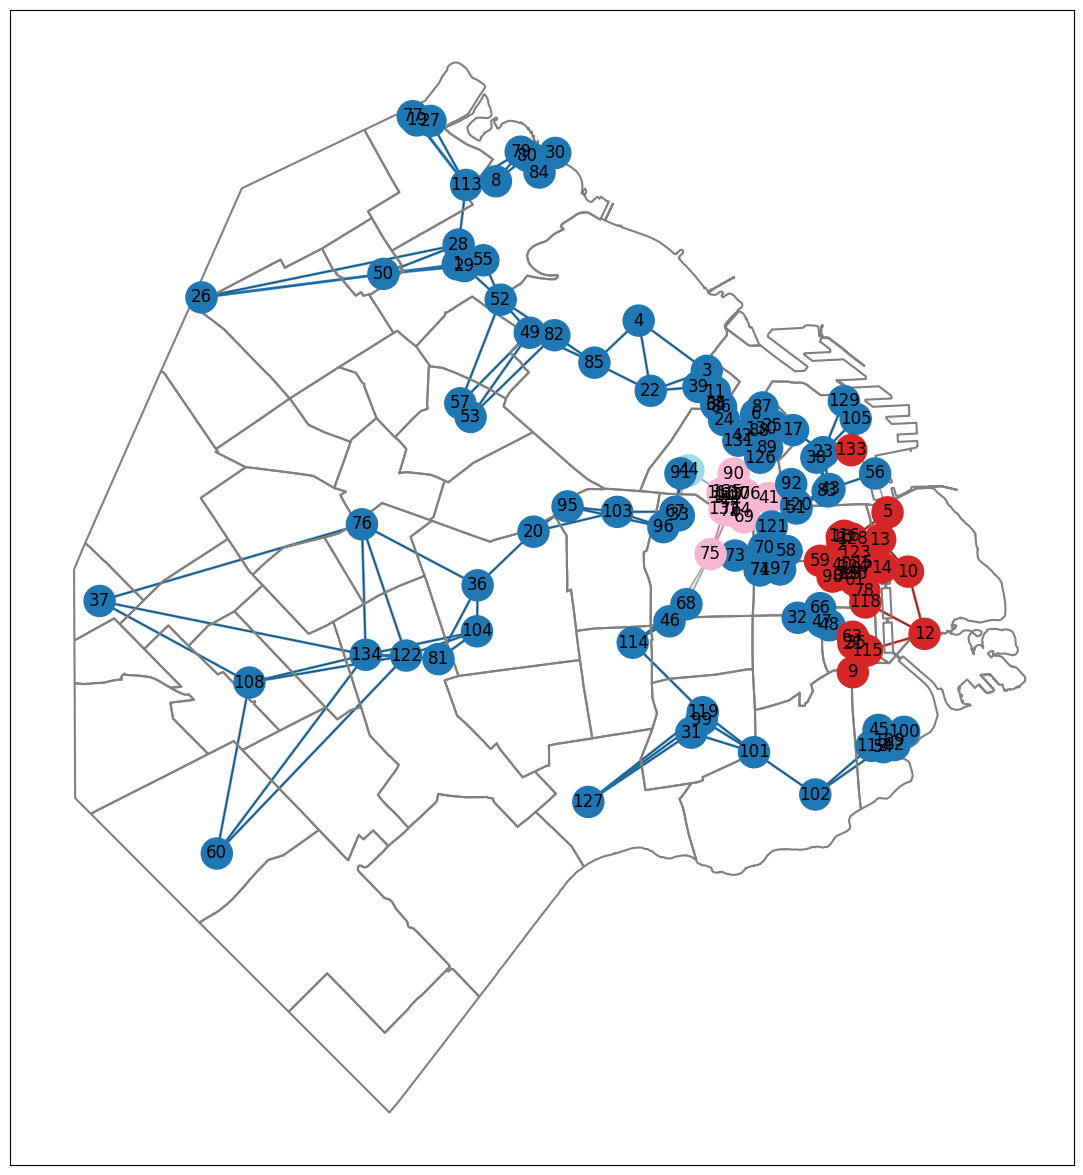

In [544]:
import template_funciones_2 as tf2
import matplotlib.patches as mpatches
#agrego la matriz de adyacencia nueva
adyacencias_m[50] = construye_adyacencia(D,50)
adyacencias_m_sim = {key: 0.5*(np.matmul(value,value.T)) for key, value in adyacencias_m.items()}

#recalculo los grafos con las matrices sim√©tricas
grafos_m = {}
valores_m = [3,5,10,50]
for m in valores_m:
    grafos_m[m] = nx.from_numpy_array(adyacencias_m[m])

#remuevo auto-aristas para todos los grafos
for g in grafos_m.values():
    g.remove_edges_from(nx.selfloop_edges(g))

comunidades_m_sim = {}
for m in valores_m:
    comunidades_m_sim[m] = tf2.modularidad_iterativo(adyacencias_m_sim[m_fijo], tf2.calcula_R(adyacencias_m_sim[m]))

print(comunidades_m_sim)

edge_colors, color_por_nodo = tf2.graficar_comunidades_en_grafo(grafos_m[3],comunidades_m_sim[3])

# Construimos un layout a partir de las coordenadas geogr√°ficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

# Visualizaci√≥n de la red en el mapa
fig, ax = plt.subplots(figsize=(15, 15)) 
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(grafos_m[3],G_layout,ax=ax,node_color=[color_por_nodo.get(nodo, "#cccccc") for nodo in G.nodes()],node_size=500) # Graficamos los museos
nx.draw_networkx_edges(
    G,
    G_layout,
    edge_color=edge_colors,
    width=2.0,  # mas gruesas para destacar
    alpha=0.7,
)



